In [1]:
import sys

import torch

sys.path.append("..")


In [2]:
from data.dataloader import LowLightDataModule
from model.blocks.featurerestorer import FeatureRestorationBlock
from model.blocks.homomorphic import ImageComposition, ImageDecomposition
from utils.utils import show_batch, summarize_model


/home/user/anaconda3/envs/jih_icicic/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_module = LowLightDataModule(
    train_dir="../data/1_train",
    valid_dir="../data/2_valid",
    bench_dir="../data/3_bench",
    infer_dir="../data/4_infer",
    image_size=512,
    batch_size=1,
    num_workers=4,
)

data_module.setup(stage="fit")


In [4]:
train_dataloader = data_module.train_dataloader()


torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


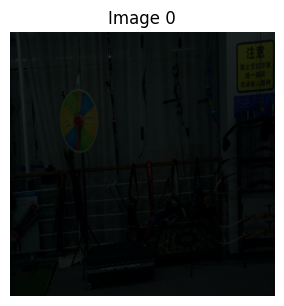

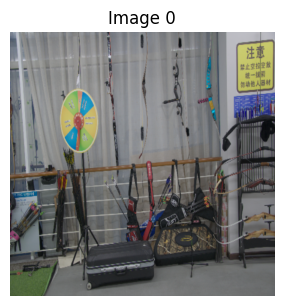

In [5]:
train_low, train_high = next(iter(train_dataloader))
print(train_low.shape)
print(train_high.shape)
show_batch(images=train_low)
show_batch(images=train_high)


In [6]:
decompose = ImageDecomposition(offset=0.5, cutoff=0.1)
compose = ImageComposition(offset=0.5)


In [7]:
train_low = train_low.cuda()
decompose = decompose.cuda()
compose = compose.cuda()


In [8]:
luminance, chroma_red, chroma_blue, illuminance, reflectance = decompose(train_low)
rgb, lu = compose(chroma_red, chroma_blue, illuminance, reflectance)


In [9]:
restore = FeatureRestorationBlock(
    in_channels=1,
    out_channels=1,
    embed_dim=32,
    num_heads=8,
    mlp_ratio=4,
    dropout_ratio=0.2,
)


In [10]:
restore = restore.cuda()


In [11]:
chroma_red, chroma_blue, reflectance = restore(chroma_red, chroma_blue, reflectance)


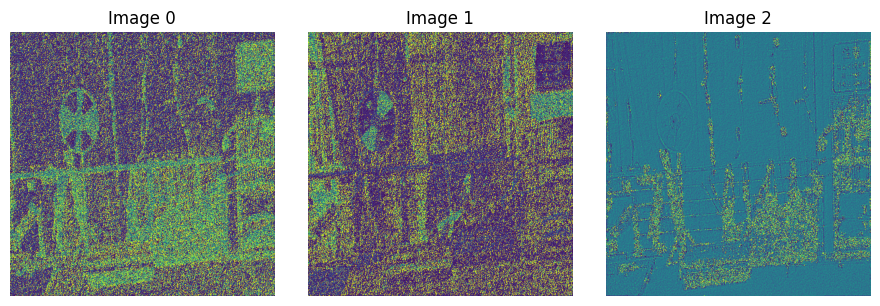

In [12]:
show_batch(images=torch.cat(tensors=[chroma_red, chroma_blue, reflectance], dim=0))


In [ ]:
input_tensors = [
    torch.randn(1, 1, 256, 256, device="cuda"),  # cr
    torch.randn(1, 1, 256, 256, device="cuda"),  # cb
    torch.randn(1, 1, 256, 256, device="cuda"),  # re
]
summarize_model(model=restore, input_data=input_tensors)


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [ResidualBlock: 2, BatchNorm2d: 3, SiLU: 3, Dropout: 3, Conv2d: 3, BatchNorm2d: 3, SiLU: 3, Dropout: 3, Conv2d: 3, Conv2d: 3, LayerNorm: 4]